In [1]:
# set up files associated with each genome coordinates
import metadensity as md
md.settings.from_config_file('/tscc/nfs/home/hsher/Metadensity/config/hg38-tscc2.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
plt.style.use('seaborn-white')
from itertools import chain
from pathlib import Path
import deepdish as dd
import os
import glob

please set the right config according to genome coordinate
Using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
Using HG38 by default
Using /tscc/nfs/home/hsher/gencode_coords/GRCh38.p13.genome.fa


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-kdwt0lio because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Using:  /tscc/nfs/home/hsher/gencode_coords/gencode.v33.transcript.gff3


This notebook looks at the relative mean intensity for canonical PAS sites that are intronic

In [2]:
base_dir = './'

In [3]:
#dd.io.load(os.path.join(base_dir, '{}_prox_passeqSite_200.h5'.format('GRB2')))

In [4]:
import numpy as np
import seaborn as sns
rna = ['IN']
#protein_coding = ['five_prime_UTR', 'first_CDS', 'CDS', 'last_CDS', 'three_prime_UTR']
################## I KNOW THIS IS INELEGANT BUT WE STILL NEED TO SET COLORS #################
color_dict = {
              'IN start': 'hotpink',
              'IN end': 'deeppink'
     }
key_to_name = {'IN': 'IN',
             }

def read_precomputed_array(uid,loc, base_dir = base_dir):
    ''' load deep dish h5 into data structure'''
    return dd.io.load(os.path.join(base_dir, '{}_{}_sample200_length200.h5'.format(uid, loc)))
def get_feature_length(denarray):
    ''' return feature length for each feature in dictionary'''
    features = list(set([d[0] for d in denarray.keys()]))
    feature_len = [denarray[f, 'left', 'rep1'].shape[1] for f in features]
    return dict(zip(features, feature_len))
def merge_two_reps(denarray, features = rna):
    ''' merge two rep, return mean density'''
    all_mean = []
    for f in features:
        for align in ['left', 'right']:

            rep1 = denarray[f, align, 'rep1']
            rep2 = denarray[f, align, 'rep2']

            all_den = np.concatenate([rep1,rep2], axis = 0) # concat into 1 array
            mean = np.nanmean(all_den, axis = 0)
            all_mean.append(mean)
    return(np.concatenate(all_mean))
def into_one_df(uids, l, features = rna):
    ''' given a list of uid, concat all features and data into 1 df'''
    all_vector = []
    i = 0
    for uid in uids:
        denarray = read_precomputed_array(uid, l)
        if i == 0:
            flen = get_feature_length(denarray)
        all_vector.append(merge_two_reps(denarray, features)) # append into results
        i+=1



    df = pd.DataFrame(np.stack(all_vector), index = uids)
    df.fillna(0, inplace = True)
    df.replace(np.nan, 0, inplace = True)

    return df , flen

def get_feat_color(features, flen):
    ''' generate color annotation for heatmap'''
    # get feature length
    colors = []
    names = []
    for f in features:
        length = flen[f]
        name = key_to_name[f]

        for align in ['start', 'end']:
            color_key = '{} {}'.format(name, align)
            names.append(color_key)
            colors += [color_dict[color_key]]*length

    return colors, names


In [5]:
full_list = set([i.split('/')[1].split('_')[0] for i in glob.glob(os.path.join('./','*.h5'))])

In [6]:
remove = [ ]

In [7]:
store_meta = {}
for c in full_list:
    store_meta[c] = {}
    for z in ['IN']:
        df, flen = into_one_df([c],z, rna)
        rna_color, names = get_feat_color(rna, flen)
        store_meta[c][z]=df
        # if strand_dict[c] == "+":  
        #     store_meta[c][z]=df
        # else:
        #     print(c,z)
        #     store_meta[c][z]=pd.DataFrame(df.T[c].tolist()[::-1]).rename(columns={0:c}).T
#     sns.lineplot(x=store_meta[c]['PROXIMAL'].T.index, y=store_meta[c]['PROXIMAL'].T[c], color='purple')
    
#     sns.lineplot(x=store_meta[c]['DISTAL'].T.index, y=store_meta[c]['DISTAL'].T[c], color='lightseagreen')
#     #sns.lineplot(x=store_meta[c]['no'].T.index, y=store_meta[c]['no'].T[c])
#     plt.title(c)
#     plt.axvline(x=200, linestyle='dashed', color='grey')
#     plt.axvline(x=400, color='black')
#     plt.axvline(x=600, linestyle='dashed', color='grey')
#     plt.legend(['PROXIMAL', 'DISTAL'])
#     plt.ylim(0)
#     plt.show()


In [8]:
store_meta = {}
for c in full_list:
    if c not in remove:
        store_meta[c] = {}
        for z in ['IN']:
            df, flen = into_one_df([c],z, rna)
            rna_color, names = get_feat_color(rna, flen)
            store_meta[c][z]=df

In [9]:
feature_info = pd.read_csv('./constitutive_intron_metadensity_features.txt', sep='\t', header=None)

In [10]:
feature_dict = feature_info.groupby(0).apply(lambda r: dict(zip(r[1], r[2]))).to_dict()

In [11]:
meta_IN_all = pd.DataFrame()
for c in store_meta:
    if c != 'CPSF5':
        if feature_dict[c]['IN'] >= 10:
            meta_IN_all = pd.concat([meta_IN_all,  store_meta[c]['IN'].assign(index_label=c)])
    else:
        if feature_dict['NUDT21']['IN'] >= 10:
            meta_IN_all = pd.concat([meta_IN_all,  store_meta['CPSF5']['IN'].assign(index_label='CPSF5')])
meta_IN_all = meta_IN_all.set_index('index_label')


In [12]:
meta_IN_all.sort_index()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
index_label,,,,,,,,,,,,,,,,,,,,,
CPSF5,9.966272e-05,1.012230e-04,1.007586e-04,9.905418e-05,1.001470e-04,1.009806e-04,1.011680e-04,1.024652e-04,1.031848e-04,1.048619e-04,...,6.592597e-06,6.673159e-06,6.397144e-06,7.115760e-06,7.540087e-06,7.285427e-06,7.420508e-06,7.236050e-06,7.713147e-06,8.350466e-06
CPSF6,1.545584e-05,1.493006e-05,1.467249e-05,1.416205e-05,1.370882e-05,1.316548e-05,1.301257e-05,1.297679e-05,1.430777e-05,1.388016e-05,...,6.300451e-06,5.849531e-06,5.584306e-06,6.092882e-06,5.876122e-06,5.492096e-06,6.136565e-06,6.245517e-06,6.504335e-06,6.337224e-06
GRB2,-1.488372e-06,-1.717360e-06,-1.951965e-06,-1.841261e-06,-2.055423e-06,-2.032597e-06,-1.647110e-06,-2.034905e-06,-2.271197e-06,-2.442634e-06,...,1.837755e-07,-2.488621e-07,3.206636e-07,1.175353e-07,9.134409e-08,2.622618e-07,6.658896e-07,8.650607e-07,7.407980e-07,8.697344e-07
MBNL2,1.409682e-05,1.447810e-05,1.442696e-05,1.415095e-05,1.378378e-05,1.339042e-05,1.317782e-05,1.334336e-05,1.350112e-05,1.334485e-05,...,1.797791e-06,1.723867e-06,1.756989e-06,1.482423e-06,1.056931e-06,8.446697e-07,5.607020e-07,4.975288e-07,4.032738e-07,4.008704e-07
RBM5,2.251623e-06,2.011725e-06,2.023707e-06,3.003786e-06,2.965776e-06,2.689741e-06,1.547836e-06,1.490301e-06,1.613664e-06,1.546987e-06,...,1.826628e-06,2.148802e-06,2.148802e-06,2.117818e-06,2.418615e-06,2.818691e-06,2.791250e-06,3.076456e-06,2.776247e-06,2.516999e-06
RNPS1,-4.650091e-07,1.731868e-07,1.731868e-07,1.196073e-07,6.254644e-07,5.377415e-07,8.482315e-07,9.124393e-07,8.080963e-07,5.796061e-07,...,4.863821e-05,4.564510e-05,4.564510e-05,4.603803e-05,4.451494e-05,4.587538e-05,4.587538e-05,4.310296e-05,4.405793e-05,4.381445e-05
TRNAU1AP,7.641866e-06,7.562098e-06,7.640205e-06,7.384866e-06,7.203304e-06,6.754376e-06,7.065854e-06,7.289102e-06,7.370845e-06,7.656328e-06,...,5.109578e-06,4.986056e-06,5.367341e-06,5.218859e-06,5.101840e-06,4.810741e-06,4.700600e-06,5.102747e-06,5.051593e-06,4.913507e-06
ZC3HAV1,4.430438e-06,4.638662e-06,4.787745e-06,4.963445e-06,4.555364e-06,4.531445e-06,4.325120e-06,3.589360e-06,3.054940e-06,3.467055e-06,...,-2.458296e-06,-2.425876e-06,-2.514579e-06,-2.489821e-06,-2.456610e-06,-2.432336e-06,-2.447397e-06,-3.042706e-06,-2.706766e-06,-3.025290e-06
ZMAT3,9.593342e-06,8.477254e-06,8.286355e-06,8.371982e-06,1.401720e-05,1.382240e-05,1.387965e-05,1.389725e-05,8.216932e-06,8.216932e-06,...,2.155118e-06,2.183585e-06,1.031825e-06,1.031825e-06,7.066562e-07,7.066562e-07,8.547290e-07,8.547290e-07,2.036852e-06,1.102036e-06


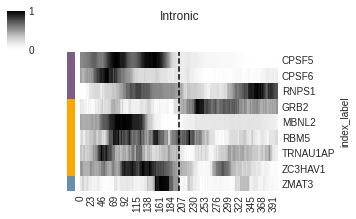

In [27]:
# Your annotation dictionary
screen_results = {
    'CPSF5': 'Upstream',
    'CPSF6': 'Upstream',
    'TRNAU1AP': 'Both',
    'GRB2': 'Both',
    'MBNL2': 'Both',
    'ZC3HAV1': 'Both',
    'RBM5': 'Both',
    'ZMAT3': 'Downstream',
    'RBM22': 'Downstream',
    'EIF4B': 'Both',
    'STAU2': 'Downstream',
    'RNPS1': 'Upstream'
}
# Make into a Series aligned with your dataframe index
annotation = pd.Series(screen_results)

# Choose a colorblind-friendly palette for categories
palette = {
    'Upstream': '#7C5D86',   # purple
    'Downstream': '#668EB1', # blue
    'Both': '#FFA500'        # green
}

row_colors = annotation.map(palette)
order = ['CPSF5', 'CPSF6', 'RNPS1'] + [g for g in meta_IN_all.sort_index().index if g not in ['CPSF5','CPSF6','RNPS1']]

g1 = sns.clustermap(
    meta_IN_all.loc[order], 
    cmap='Greys',
    row_cluster=False, col_cluster=False,
    figsize=(5, 3), 

    standard_scale=0,
    #alpha=0.8
    row_colors=row_colors
)
g1.ax_heatmap.axvline(x=200, color='black', linestyle='--')
g1.fig.suptitle('Intronic')  # title for clustermap

g1.savefig('heatmap_constitutive_intronic.png')
g1.savefig('heatmap_constitutive_intronic.svg')
g1.savefig('heatmap_constitutive_intronic.jpg')